# Vision Transformers from scratch

- [ViT Blogpost by Francesco Zuppichini](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)
- [D2L Tutorial ](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [Brian Pulfer Medium Blogpost](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)
- [Lucidrains implementation Github ](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)

## Setup

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.3 MB/s eta 0:00:00


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
import cv2
import numpy as np
import re

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                # Extract the label from the filename using a regular expression
                match = re.search(r'\d{4}-\d{2}-\d{2}', filename)
                if match:
                    label = match.group(0)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Replace 'YourDatasetFolder' with the actual path to your dataset folder
dataset_folder = "/content/drive/MyDrive/Dataset/oxford-iiit-pet/images/"

x_train, y_train = load_images_from_folder(dataset_folder)

# Print the size of the loaded data
print("Size of X_train:", len(x_train))
print("Size of y_train:", len(y_train))

Size of X_train: 744
Size of y_train: 744


<ipython-input-19-ded0bdc680bb>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


## Image Patching



[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

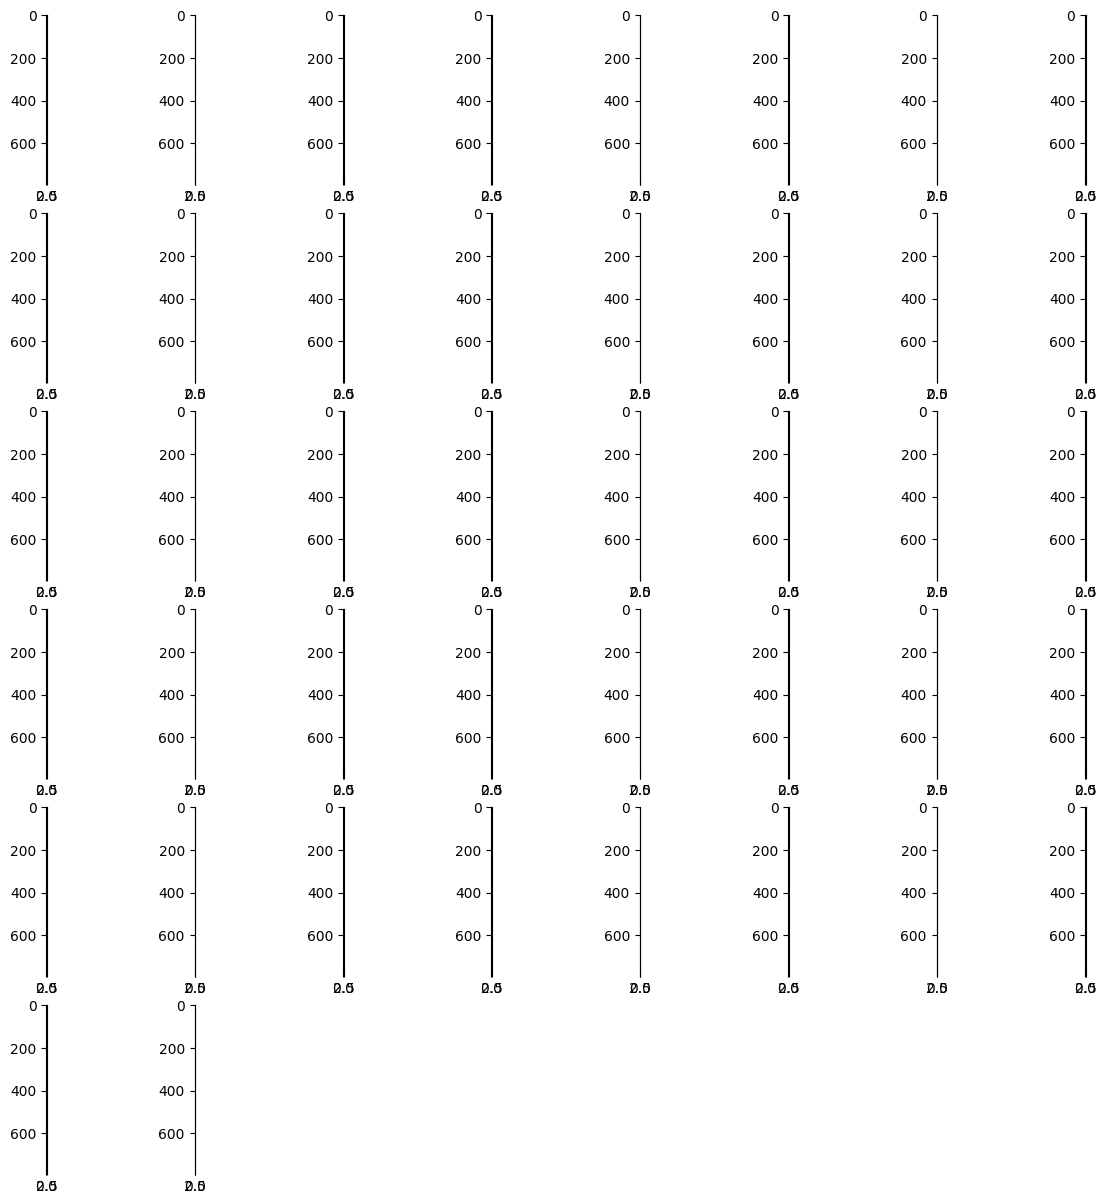

In [20]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(x_train) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

# 200 images for each pet
#dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(x_train)

### Patch Images

- The following is mainly from the above implementations (not my code)

In [3]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


## Model

Let's first implement all of the transformer building blocks. These blocks are inspired by the implementations linked above. I've left out some dropouts and normalizations at some places.

In [4]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [5]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [7]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [8]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [9]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [10]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

- Not all parameters are like in the original implementation
- Some Dropouts & Norms are missing

In [11]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[-0.6577,  0.2766,  0.0093,  0.2374,  0.0527, -0.4198,  0.4363, -0.5853,
          0.6288,  0.4053, -0.5783,  0.9589,  0.3575,  0.9867, -0.3832, -0.7005,
         -0.1874,  0.4856, -0.2808, -0.1421, -0.4593, -0.0381, -0.4116,  0.6126,
          0.9081,  0.3736,  0.4050,  0.2799,  0.4080, -0.3826,  0.4719, -0.6705,
          0.9176, -0.4991, -1.3026,  0.1844, -0.2064]],
       grad_fn=<AddmmBackward0>)

## Training

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [13]:
import torch.optim as optim
import numpy as np

device = "cpu"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        # model.eval()
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  3.6484713113826253
>>> Epoch 0 test loss:  3.6409988506980566
>>> Epoch 5 train loss:  3.6257995056069414
>>> Epoch 5 test loss:  3.625913495602815
>>> Epoch 10 train loss:  3.6237179533295008
>>> Epoch 10 test loss:  3.626405633014181
>>> Epoch 15 train loss:  3.6179149746894836
>>> Epoch 15 test loss:  3.6271094757577647


In [14]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([30,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 30,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])
Actual classes tensor([31, 17, 36, 11, 20, 31,  9,  1, 16,  5, 19, 30, 12, 23, 11,  8,  4, 26,
        10,  7,  8, 14, 21,  5, 36, 22, 22, 34, 28,  2,  1,  6])


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'labels' and 'outputs' are torch tensors

# Convert the outputs to predicted labels
predicted_labels = outputs.argmax(dim=-1)

# Convert torch tensors to numpy arrays for compatibility with sklearn functions
predicted_labels_np = predicted_labels.cpu().numpy()
labels_np = labels.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(labels_np, predicted_labels_np)
precision = precision_score(labels_np, predicted_labels_np, average='weighted')
recall = recall_score(labels_np, predicted_labels_np, average='weighted')
f1 = f1_score(labels_np, predicted_labels_np, average='weighted')
conf_matrix = confusion_matrix(labels_np, predicted_labels_np)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.0625
Precision: 0.004166666666666667
Recall: 0.0625
F1 Score: 0.0078125
Confusion Matrix:
[[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This needs to train much longer :)